# Queremos implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam o no basándonos en su URL.

### Importación de librerias.

In [108]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
tqdm.pandas()
import progress
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from pickle import dump


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Tratamiento de datos: 

* Lectura de datos.
* Verificación y limpieza de los datos.


In [109]:
data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")


In [110]:
data.isna().sum()

url        0
is_spam    0
dtype: int64

In [111]:
data.duplicated().sum()

630

In [112]:
data = data.drop_duplicates()

In [113]:
data.duplicated().sum()

0

In [114]:
data.shape

(2369, 2)

In [115]:
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Creamos la variable con valores numéricos para trabajar de manera correcta con el modelo.

In [116]:
data["is_spam"] = data["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
data.head(5)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


#### Creamos una funsión para procesar el texto:

* Elimina caracteres que no sean letras.
* Separa por un espacio en blanco.
* Tokeniza el texto. 
* Eliminación de acentos.
* Elimina de las Stopwords.
* Lematización de las palabras.


In [117]:
def preprocess_url(text):
    
    # Eliminar cualquier carácter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Multiples espacios en blanco, en uno
    text = re.sub(r'\s+', " ", text.lower())

    # Elimina etiquetas
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    # Tokenización del texto
    tokens = word_tokenize(text)

    # Eliminación de los acentos
    tokens = [unidecode(token) for token in tokens]

    # Eliminación de las stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lematización de palabras
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
  
    return ' '.join(tokens)

In [118]:
url_aleatoria = data.sample(1).url.values[0]
print(f"La url antes de ser preprocesada :\n{url_aleatoria}")
url_aleatoria_pre = preprocess_url(url_aleatoria)
print(f"Url tas ser procesada:\n {url_aleatoria_pre}")

La url antes de ser preprocesada :
https://www.reddit.com/r/nextfuckinglevel/comments/hct4tz/this_fitness_freak_simultaneously_solves_rubiks/
Url tas ser procesada:
 http www reddit com r nextfuckinglevel comment hct tz fitness freak simultaneously solves rubiks


In [119]:
data['url_pre'] = data.url.progress_apply(preprocess_url)

 13%|█▎        | 317/2369 [00:00<00:00, 3163.76it/s]

100%|██████████| 2369/2369 [00:00<00:00, 3605.85it/s]


In [120]:
data_fn = data.drop(["url"], axis=1)

In [121]:
data_fn.to_csv("/workspaces/NLP/data/processed/Data_Limpia.csv")

In [122]:
print(f"La cantidad de duplicados es de : {data_fn.url_pre.duplicated().sum()}")

La cantidad de duplicados es de : 71


In [123]:
data_fn.drop_duplicates(subset="url_pre", inplace=True)
print(f'El dataset se compone de un total de {data_fn.shape[0]} url.')

El dataset se compone de un total de 2298 url.


In [124]:
data_fn.isna().sum()

is_spam    0
url_pre    0
dtype: int64

In [125]:
print(f"El conjunto de datos está dividido por cada conjunto de variables en: {data_fn['is_spam'].astype(str).value_counts()}")


El conjunto de datos está dividido por cada conjunto de variables en: is_spam
0    2060
1     238
Name: count, dtype: int64


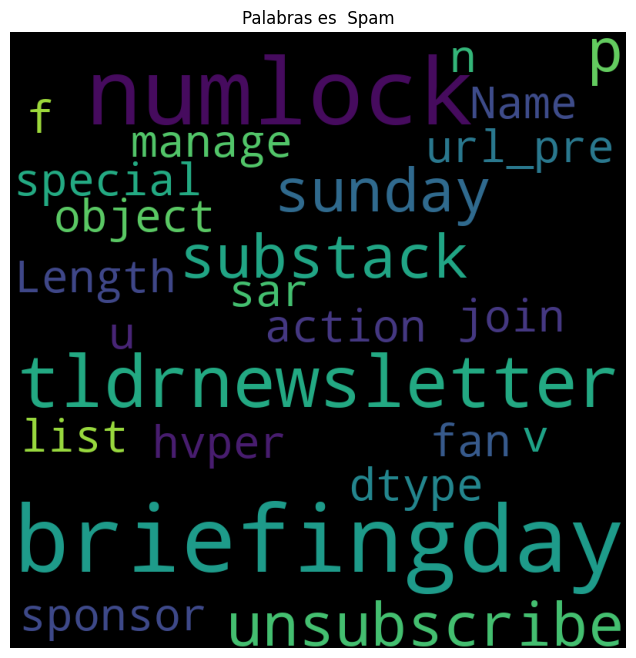

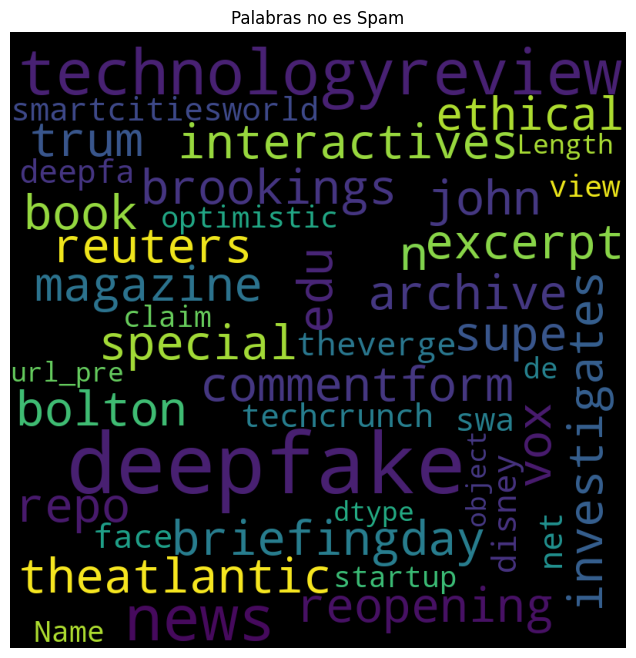

In [126]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Supongamos que data_fn es tu DataFrame con una columna 'url_pre' y 'is_spam'
data_fn_1 = data_fn[data_fn['is_spam'] == 1]
data_fn_0 = data_fn[data_fn['is_spam'] == 0]

# Palabras es Spam
wordcloud_1 = WordCloud(width=800, height=800, background_color="black", max_words=1000, min_font_size=20, random_state=42)\
    .generate(str(data_fn_1["url_pre"]))

# Palabras no es Spam
wordcloud_0 = WordCloud(width=800, height=800, background_color="black", max_words=1000, min_font_size=20, random_state=42)\
    .generate(str(data_fn_0["url_pre"]))

# Grafica de es Spam
fig_1 = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_1)
plt.axis("off")
plt.title("Palabras es  Spam")
plt.show()

# Grafica no es Spam
fig_0 = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_0)
plt.axis("off")
plt.title("Palabras no es Spam")
plt.show()


### Tratamiento de datos:
* Separación en grupos de prueba y entrenamiento.
* Vectorización de datos.

In [127]:
X_train, X_test, y_train, y_test = train_test_split(data_fn.url_pre, data_fn.is_spam, test_size=0.2, random_state=42)

In [128]:
# Crear la versión vectorizada de los textos desechando palabras que aparezcan en menos del 0.1% de los documentos
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X_train_num = vectorizer.fit_transform(X_train)
X_test_num = vectorizer.transform(X_test)

In [129]:
print(X_train_num.shape)
print(X_test_num.shape)

(1838, 521)
(460, 521)


#### Aplicamos el modelos de regresion logistica.

In [130]:
clf = LogisticRegression().fit(X_train_num, y_train)
y_pred = clf.predict(X_test_num)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       417
           1       1.00      0.40      0.57        43

    accuracy                           0.94       460
   macro avg       0.97      0.70      0.77       460
weighted avg       0.95      0.94      0.93       460



In [131]:
clf_md = LogisticRegression(class_weight='balanced', penalty='l2').fit(X_train_num, y_train)
y_pred = clf_md.predict(X_test_num)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.89      0.93       417
           1       0.40      0.72      0.52        43

    accuracy                           0.87       460
   macro avg       0.69      0.81      0.72       460
weighted avg       0.92      0.87      0.89       460



Al ver que los datos están muy desbalanceados, aplicamos el parámetro para que sean balanceados y vemos el impacto que crea, en la métricas se refleja que el modelo tiene problemas para detectar los que son Spam.

Aplicaremos el modelo SVC, para poder determinar si el mismo consigue mejores resultados.

In [132]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42, class_weight='balanced')
model.fit(X_train_num, y_train)

SVC(class_weight='balanced', kernel='linear', random_state=42)

In [133]:
y_pred = model.predict(X_test_num)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       417
           1       0.35      0.65      0.46        43

    accuracy                           0.85       460
   macro avg       0.66      0.76      0.69       460
weighted avg       0.90      0.85      0.87       460



#### El modelo de regresion logistica logra tener mejores resultados que el SVC.

    Procedemos a buscar mejores hiperparametros de ambos modelos y así determinar cual consigue mejores resultados.

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Definir los parámetros a ajustar y sus posibles valores
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 500],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500]
}

# Crear el clasificador de regresión logística
logreg_model = LogisticRegression()

# Configurar la búsqueda de cuadrícula
grid_search = GridSearchCV(logreg_model, param_grid, scoring='f1', cv=5)

# Realizar la búsqueda de cuadrícula en los datos
grid_search.fit(X_train_num, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.

Mejores hiperparámetros: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1440 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return f

In [135]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a ajustar y sus posibles valores
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 0.01, 0.001]}

# Crear el clasificador SVM
svm_model = SVC()

# Configurar la búsqueda de cuadrícula
grid_search = GridSearchCV(svm_model, param_grid, scoring='f1', cv=5)  # Puedes ajustar la métrica de puntuación y la validación cruzada

# Realizar la búsqueda de cuadrícula en los datos vectorizados
grid_search.fit(X_train_num, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)


Mejores hiperparámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [136]:
# Crear el clasificador regresor con los mejores hiperparámetros
best_regresor_model = LogisticRegression(C= 10, max_iter= 100, penalty= 'l1', solver= 'liblinear')

# Entrenar el modelo en los datos vectorizados
best_regresor_model.fit(X_train_num, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_regresor_model.predict(X_test_num)

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       417
           1       0.68      0.53      0.60        43

    accuracy                           0.93       460
   macro avg       0.81      0.75      0.78       460
weighted avg       0.93      0.93      0.93       460



In [137]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Crear el clasificador SVM con los mejores hiperparámetros
best_svm_model = SVC(C=10, gamma=0.1, kernel='rbf')

# Entrenar el modelo en los datos vectorizados
best_svm_model.fit(X_train_num, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_svm_model.predict(X_test_num)

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       417
           1       0.87      0.47      0.61        43

    accuracy                           0.94       460
   macro avg       0.91      0.73      0.79       460
weighted avg       0.94      0.94      0.94       460



#### Informe de Evaluación del Modelo de Detección de Spam

Se realizó una evaluación exhaustiva del modelo de detección de spam utilizando un clasificador de Máquinas de Soporte Vectorial (SVM) con los mejores hiperparámetros optimizados a través de técnicas de búsqueda. El modelo se entrenó y evaluó utilizando un conjunto de datos de prueba.

A continuación se presentan los resultados del modelo:

* Precisión (Precision):

Para la clase 0 (no spam), se logró una alta precisión del 95%, indicando que el 95% de las instancias predichas como no spam son correctas.
Para la clase 1 (spam), la precisión alcanzó un nivel respetable del 87%, lo que significa que el 87% de las instancias predichas como spam son correctas.

* Recall:

La clase 0 exhibió un recall excepcionalmente alto del 99%, indicando que el modelo identifica correctamente el 99% de las instancias reales de no spam.
La clase 1 mostró un recall más modesto del 47%, sugiriendo que el modelo identifica el 47% de las instancias reales de spam.

* F1-Score:

El F1-score para la clase 0 fue muy elevado, alcanzando un 97%, indicando un buen equilibrio entre precision y recall.
Aunque el F1-score para la clase 1 mejoró a 61%, todavía existe margen para una mejora adicional.

* Exactitud (Accuracy):

La precisión global del modelo fue del 94%, reflejando la proporción de predicciones correctas en general.
Puntuaciones Macro y Ponderadas (Macro y Weighted Avg):

La media ponderada (weighted avg) tuvo en cuenta el desequilibrio de clases y alcanzó un 94%, lo que sugiere que el modelo generaliza bien a través de ambas clases.
Conclusiones y Recomendaciones:

El modelo presenta un rendimiento sólido en la identificación de correos electrónicos no spam, con altas precisiones y recalls. Sin embargo, se observa un desafío en la identificación de correos spam, especialmente en términos de recall.

Se recomienda explorar estrategias adicionales para mejorar la detección de spam, como ajustar el umbral de decisión del modelo, utilizar técnicas de remuestreo para abordar el desequilibrio de clases, o considerar modelos más avanzados que puedan capturar patrones más complejos en los datos.

El rendimiento del modelo debe evaluarse continuamente y ajustarse según sea necesario para adaptarse a cambios en el conjunto de datos o en las necesidades específicas del problema.

Este informe proporciona una visión general de la efectividad del modelo de detección de spam y sirve como base para futuras iteraciones y mejoras.

In [139]:
dump(best_regresor_model,open("/workspaces/NLP/models/models.sav", "wb"))